In [1]:
#intialize the GPU
import tensorflow as tf
from tensorflow import keras

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
print(tf.version.VERSION)

2.6.0


In [5]:
import sys
sys.version

'3.9.11 (main, Mar 30 2022, 02:45:55) [MSC v.1916 64 bit (AMD64)]'

In [6]:
import os
os.getcwd()

'C:\\Users\\dsald\\Documents\\Deep Learning Projects\\CNN'

#Modeling 

Mapping the Final scrapped images stored in different file paths to the corresponding train, validation and test directory to be introduced into the CNN

In [7]:
train_dir = 'C:\\Users\\dsald\\Documents\\Deep Learning Projects\\CNN\\ImagesDataset\\train' # train data

In [8]:
validation_dir = 'C:\\Users\\dsald\\Documents\\Deep Learning Projects\\CNN\\ImagesDataset\\validation'   # validation data

In [9]:
test_dir = 'C:\\Users\\dsald\\Documents\\Deep Learning Projects\\CNN\\ImagesDataset\\test' # test data

## Data Augmentation & Regularized model (model2)
 
From the above plots of the model we can see that our training accuracy increases almost linearly till reaching 100%, however our validation loss has stalled at 80%. Also our validation loss reaches its minimum after 5 epochs and keeps decreasing almost linearly till it reaches 0. 

We notice a case of underfitting here and we will leverage the use of data augmentation techniques, therby generating more training data from existing trainig samples and augmenting the samples via a number of random transformations that yield believable-looking images. This way the model neve sees the exact same picture twice and is exposed to more aspects of the data and helps build a more robust model. 

In [10]:
#define datagen functifrom keras.preprocessing.image import ImageDataGeneratoron
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Example of how an agumented image will be:

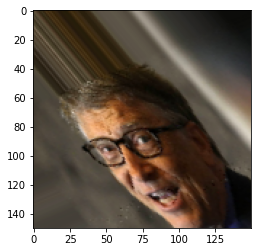

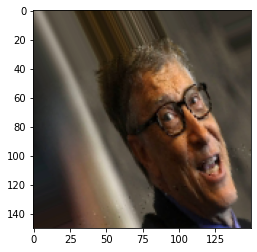

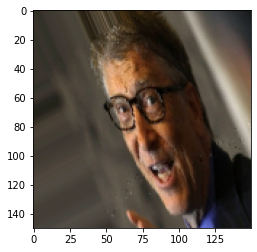

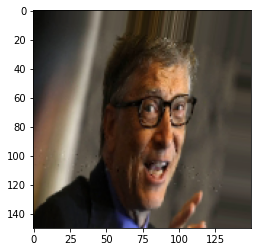

In [11]:
# Import image preprocessing utilities
from keras.preprocessing import image
#from google.colab import files
import matplotlib.pyplot as plt

# We pick one image to "augment"
img_path = train_dir + '//people wearing specs//17.getty_499436010_200014082000928089_358414.jpg'

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Now that we have completed our data augmentation above, we will re-train the model using dropout layers and adding Early Stopping to stop the model from overfitting and enhance the robustness of the current model architecture.

In [64]:
#adding droup out after each conv2d and maxpooling layer to increase robustness of model
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import layers
from keras import models

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(2, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=10,
                   verbose=2,
                   restore_best_weights=True)

In [13]:
#check the model
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Proceed to train network using data augmentation, dropout & EarlyStopping

In [14]:
#import required callback package for earlystopping
from keras import callbacks
import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# we simply scale it by the max value (255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')


#fit the model
history = model2.fit_generator(
      train_generator,
      steps_per_epoch=20, # Ideally 574/20 ~ 28
      epochs=100,
      validation_data=validation_generator,
      validation_steps=9, # Ideally 180/20 = 9
      callbacks = [es]) 

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


C:\Users\dsald\anaconda3\envs\deployment\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 16s 506ms/step - loss: 0.7085 - acc: 0.5175 - val_loss: 0.6917 - val_acc: 0.5000
Epoch 2/100
 4/20 [=====>........................] - ETA: 5s - loss: 0.7032 - acc: 0.5000

C:\Users\dsald\anaconda3\envs\deployment\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 14s 701ms/step - loss: 0.6879 - acc: 0.5875 - val_loss: 0.6757 - val_acc: 0.5833
Epoch 3/100
20/20 [==============================] - 9s 467ms/step - loss: 0.6941 - acc: 0.5650 - val_loss: 0.6953 - val_acc: 0.4944
Epoch 4/100
20/20 [==============================] - 10s 461ms/step - loss: 0.6891 - acc: 0.4825 - val_loss: 0.6929 - val_acc: 0.5111
Epoch 5/100
20/20 [==============================] - 9s 477ms/step - loss: 0.6864 - acc: 0.5900 - val_loss: 0.6946 - val_acc: 0.6000
Epoch 6/100
20/20 [==============================] - 9s 454ms/step - loss: 0.6631 - acc: 0.6325 - val_loss: 1.0608 - val_acc: 0.4889
Epoch 7/100
20/20 [==============================] - 9s 442ms/step - loss: 0.6773 - acc: 0.6000 - val_loss: 0.6961 - val_acc: 0.5778
Epoch 8/100
20/20 [==============================] - 9s 442ms/step - loss: 0.6524 - acc: 0.6425 - val_loss: 0.7788 - val_acc: 0.5444
Epoch 9/100
20/20 [==============================] - 9s 446ms/step - loss: 0.65

### Plot the results


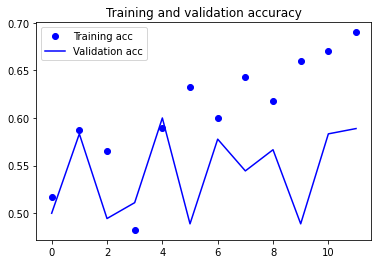

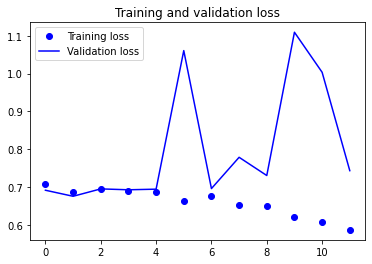

In [15]:
acc = history.history['acc'] # training accuracy
val_acc = history.history['val_acc'] # validation accuracy
loss = history.history['loss'] # training loss
val_loss = history.history['val_loss'] # validtion loss

epochs = range(len(acc))

#plot training acc as dots and validation acc as a line to realize the resulting trend
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

##plot training loss as dots and validation loss as a line to realize the resulting trend
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*  The overall robustness of the model has improved.
* Using dropout layers has helped enhance the training accuracy (81%), however hasnt had the same impact on the validation accuracy (66%)


### Confusion Matrix of our Regularized Model

Found 200 images belonging to 2 classes.


C:\Users\dsald\anaconda3\envs\deployment\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


                      precision    recall  f1-score   support

         people face       0.49      0.42      0.45       100
people wearing specs       0.49      0.56      0.52       100

            accuracy                           0.49       200
           macro avg       0.49      0.49      0.49       200
        weighted avg       0.49      0.49      0.49       200



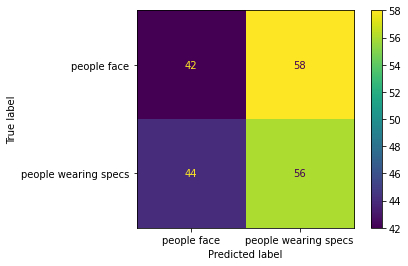

In [16]:
#Generate Confusion matrix & Classification Report using test data. 
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = test_generator.flow_from_directory(
    test_dir, # test data path here
     target_size=(150, 150),
    batch_size=20,
    shuffle=False)

#model2
predictions = model2.predict_generator(test_data_generator, steps=10) 
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys()) 

#Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

#Confusion Matrix
cm = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
labels=class_labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()


* From the regularization using dropout layers,earlystopping, various hyperparameter tunning (via batchsize, epochs etc) and data augmentation the robustness of the model has significantly improved and can be gauged from the metric plots however the accuracy of the model was unable to be improved much, owing to the very small dataset. 

* We will try to leverage the use of pre-trained models avaialable in the keras packages to achieve this higher accuracy model. 
* We can also see that from the confusion matrix (test accuracy 73%) a large number of images are correctly classified as peopel wearing specs which is our target variable as compared to the intial model.
* However trying to further improve this model via various ways like regularization, adding, droping layers is time and commute intensive and we should try to leverage the predictive power of pre-trained models (transfer learning)

# Build using VGG16 architecture (model3)


For our purposes we will not be making use of the fully connected layers and softmax layer from this architecture, rather our dense layer will be trained based on our custom classification problem requirements


In [65]:
from keras.applications.vgg16 import VGG16
 
conv_base = VGG16(weights='imagenet', # weights from imagenet - very important! otherwise it's just the network structure
                  include_top=False, # this means that our dense layer will be trained specific to our small data problem that we are solving
                  input_shape=(150, 150, 3)) # this is the shape of the data from our data generator (we know cats vs. dogs is 150 x 150)

In [66]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We will start by running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [19]:
#automated feature engineering
from datetime import datetime
import numpy as np
startTime = datetime.now()

# initialize your generator
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # this is given from the VGG16 architecture!
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 600) 
print(datetime.now() - startTime)
validation_features, validation_labels = extract_features(validation_dir, 200)
print(datetime.now() - startTime)
test_features, test_labels = extract_features(test_dir, 200)
print(datetime.now() - startTime)

Found 600 images belonging to 2 classes.


C:\Users\dsald\anaconda3\envs\deployment\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


0:00:13.909365
Found 200 images belonging to 2 classes.
0:00:17.020799
Found 200 images belonging to 2 classes.
0:00:20.479837


In [20]:
# these are the X features for modeling
train_features = np.reshape(train_features, (600, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (200, 4 * 4 * 512))
test_features = np.reshape(test_features, (200, 4 * 4 * 512))

In [21]:
#define the model for the densely-connected classifier
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers

model3 = models.Sequential()
model3.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model3.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


C:\Users\dsald\anaconda3\envs\deployment\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


30/30 [==============================] - 1s 7ms/step - loss: 0.7200 - acc: 0.5517 - val_loss: 0.6436 - val_acc: 0.6450
Epoch 2/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5802 - acc: 0.7000 - val_loss: 0.6185 - val_acc: 0.6800
Epoch 3/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5122 - acc: 0.7600 - val_loss: 0.6265 - val_acc: 0.6850
Epoch 4/30
30/30 [==============================] - 0s 4ms/step - loss: 0.4609 - acc: 0.7867 - val_loss: 0.6208 - val_acc: 0.6950
Epoch 5/30
30/30 [==============================] - 0s 4ms/step - loss: 0.4158 - acc: 0.8183 - val_loss: 0.5950 - val_acc: 0.7100
Epoch 6/30
30/30 [==============================] - 0s 4ms/step - loss: 0.3865 - acc: 0.8367 - val_loss: 0.5984 - val_acc: 0.7100
Epoch 7/30
30/30 [==============================] - 0s 4ms/step - loss: 0.3573 - acc: 0.8650 - val_loss: 0.5921 - val_acc: 0.7150
Epoch 8/30
30/30 [==============================] - 0s 4ms/step - loss: 0.3251 - acc: 0.8733 - val_lo

Fastest compute time and best training accuracy at 96%

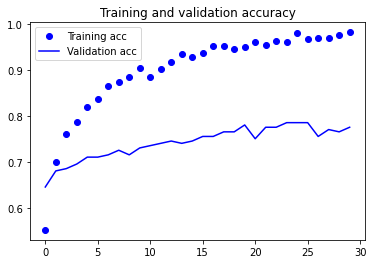

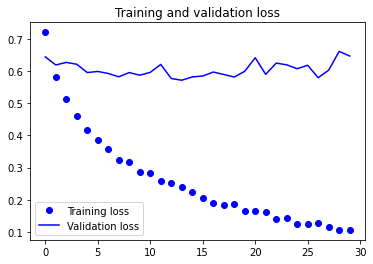

In [22]:
#Plot the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Using Freezing (model4) & VGG16

By Freezing the convolution(image processing) portion of the DCNN we will only be updating the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector).

In [169]:
#import required packages and build model using the freezing of the conv base
from keras import models
from keras import layers

model4 = models.Sequential()
model4.add(conv_base)
model4.add(Dropout(0.2))
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(layers.Dense(2, activation='sigmoid'))

In [170]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model4.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [171]:
#freeze the convlution base of the pre-trained model 
conv_base.trainable = False

In [172]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model4.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [173]:
#using batch_size = 20
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

#data augmentation of training data
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='wrap')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=22,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=22,
        class_mode='categorical')
    

model4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [177]:
#fit the model
history = model4.fit( #model.fit_generator(
      train_generator,
      steps_per_epoch=25, # Ideally...600/20 ~30
      epochs=100, 
      validation_data=validation_generator,
      validation_steps=8, # 200/20 == 10
      verbose=1,
      callbacks = [es])

Epoch 1/100
25/25 [==============================] - 12s 480ms/step - loss: 0.2841 - acc: 0.8783 - val_loss: 0.8170 - val_acc: 0.7500
Epoch 2/100
25/25 [==============================] - 12s 480ms/step - loss: 0.2734 - acc: 0.8745 - val_loss: 0.7289 - val_acc: 0.7443
Epoch 3/100
25/25 [==============================] - 12s 484ms/step - loss: 0.2666 - acc: 0.8895 - val_loss: 0.7042 - val_acc: 0.7500
Epoch 4/100
25/25 [==============================] - 12s 435ms/step - loss: 0.2953 - acc: 0.8577 - val_loss: 0.7334 - val_acc: 0.7386
Epoch 5/100
25/25 [==============================] - 11s 451ms/step - loss: 0.2873 - acc: 0.8783 - val_loss: 0.7045 - val_acc: 0.7443
Epoch 6/100
25/25 [==============================] - 12s 478ms/step - loss: 0.3043 - acc: 0.8577 - val_loss: 0.5781 - val_acc: 0.7386
Epoch 7/100
25/25 [==============================] - 11s 463ms/step - loss: 0.2877 - acc: 0.8839 - val_loss: 0.7455 - val_acc: 0.7386
Epoch 8/100
25/25 [==============================] - 12s 466ms

### Plot Results

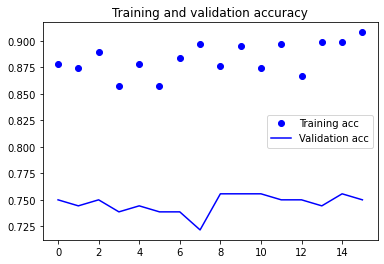

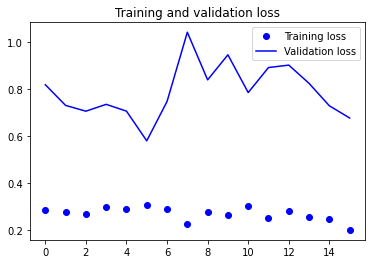

In [178]:
#Plot Results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Adding Dropout improved the model robustness and decreases the overfitting. 

Found 200 images belonging to 2 classes.


C:\Users\dsald\anaconda3\envs\deployment\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


                      precision    recall  f1-score   support

         people face       0.79      0.75      0.77       100
people wearing specs       0.76      0.80      0.78       100

            accuracy                           0.78       200
           macro avg       0.78      0.78      0.77       200
        weighted avg       0.78      0.78      0.77       200



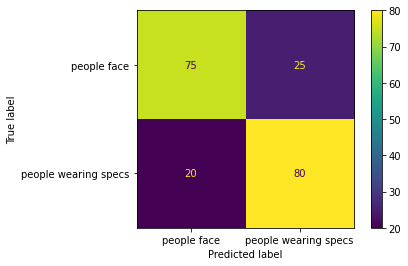

In [179]:
#Generate Confusion matrix & Classification Report using test data. 
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = test_generator.flow_from_directory(
    test_dir, # test data path here
    target_size=(150, 150),
    batch_size=20,
    shuffle=False)

#model4
predictions = model4.predict_generator(test_data_generator, steps=10) # 200/20 = 10
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys()) 

#Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

#Confusion Matrix
cm = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
labels=class_labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

From the confusion matrix we see that our accuracy/robustness of our model has improved as lesser images are classified under false negative and false negative.

In [38]:
#save final model

model4.save('C:\\Users\\dsald\\Documents\\Deep Learning Projects\\model4.h5')